In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import torch
import random

U narednom dijelu koda cu pomocu klase implementirati CartPole model

In [2]:
class CartPole:
    def __init__(self, m, M, l, x_max, k):
        "Konstruktor koji formira parametre okruzenja"
        self.m = m
        self.M = M
        self.l = l
        self.x_max = x_max
        self.k = k
        self.g = 9.81

        self.state = [0.0, 0.0, 0.0, 0.0]

        "Najcesce se uzima ova perioda posto je sistem diskretan"
        self.T = 0.02

        self.done = False
    "Primjena sile tj., ubacivanje ulaza"
    def stepForce(self, action):

        "Diskretne akcije"
        if action == 0:
            F = 10
        elif action == 1:
            F = -10

        x = self.state[0]
        x_dot = self.state[1]
        theta = self.state[2]
        theta_dot = self.state[3]

        "Razlaganje formule na manje dijelove"
        part1_theta = self.M * self.g * math.sin(theta)
        part1_x = self.m * self.g * math.cos(theta) * math.sin(theta)
        common_part_1 = F + self.m * self.l * np.square(theta_dot) * math.sin(theta)
        common_part_2 = (1 + self.k)
        common_part_3 = self.m * np.square(math.cos(theta))

        theta_dot_dot = (part1_theta - math.cos(theta) * common_part_1) / (common_part_2 * self.M * self.l - common_part_3 * self.l)

        x_dot_dot = (part1_x - common_part_2 * common_part_1) / (common_part_3 - common_part_2 * self.M)

        "Pakovanje novih stanja"
        new_x = x + self.T * x_dot
        new_x_dot = x_dot + self.T * x_dot_dot
        new_theta = theta + self.T * theta_dot
        new_theta_dot = theta_dot + self.T * theta_dot_dot

        self.state = [new_x, new_x_dot, new_theta, new_theta_dot]

        return self.state

    def retState(self):
        return self.state

    "Provjera jel epizoda gotova"
    def isDone(self):
        if abs(self.state[0]) > self.x_max:
            self.done = True
        elif abs(self.state[2]) * ( 180 / math.pi ) > 30:
            self.done = True
        else:
            self.done = False
        return self.done

    "Resetovanje modela"
    def resetCartPole(self):
        self.done = False
        self.state = [0.0, 0.0, 0.0, 0.0]
        self.state[2] = np.random.uniform(-0.1, 0.1) #Da pocetni ugao ne bude bas 0
        return self.state


Ovo je implementacija modela,sada slijedi test simulacija,radi potvrde da je model upotrebljiv

In [3]:
"Parametri kreiranja objekta klase CartPole(m, M , l, x_max, k), x_max-maksimalno pomjeranje po x-osi u oba pravca"
cart = CartPole(0.1, 1.1, 0.5, 2.48, 0.33)

akcija = 0

cart.state[2] = 0.05

for i in range(100):
    cart.stepForce(akcija) # Bez sile, samo gravitacija
    print(f"Korak {i}: Ugao u radijanima = {cart.state[2]:.4f}")

Korak 0: Ugao u radijanima = 0.0500
Korak 1: Ugao u radijanima = 0.0445
Korak 2: Ugao u radijanima = 0.0334
Korak 3: Ugao u radijanima = 0.0167
Korak 4: Ugao u radijanima = -0.0056
Korak 5: Ugao u radijanima = -0.0337
Korak 6: Ugao u radijanima = -0.0677
Korak 7: Ugao u radijanima = -0.1078
Korak 8: Ugao u radijanima = -0.1541
Korak 9: Ugao u radijanima = -0.2070
Korak 10: Ugao u radijanima = -0.2665
Korak 11: Ugao u radijanima = -0.3331
Korak 12: Ugao u radijanima = -0.4068
Korak 13: Ugao u radijanima = -0.4880
Korak 14: Ugao u radijanima = -0.5768
Korak 15: Ugao u radijanima = -0.6734
Korak 16: Ugao u radijanima = -0.7779
Korak 17: Ugao u radijanima = -0.8904
Korak 18: Ugao u radijanima = -1.0107
Korak 19: Ugao u radijanima = -1.1387
Korak 20: Ugao u radijanima = -1.2743
Korak 21: Ugao u radijanima = -1.4172
Korak 22: Ugao u radijanima = -1.5669
Korak 23: Ugao u radijanima = -1.7231
Korak 24: Ugao u radijanima = -1.8852
Korak 25: Ugao u radijanima = -2.0526
Korak 26: Ugao u radijanim

Test pokazuje da se model dobro ponasa.
Sada krece implementacija algoritama.
Kao prvo ide funkcija koja vrsi formiranje nagrade.
Sama logika kreiranje nagrade je:
Imam granicni ugao od 30 stepeni, i kada stap padne ispod te granice epizoda je gotova, i imam dvije zone, kada je apsolutni ugao manji od 15 stepeni i to je da kazem najbolja jer tu se ostvaruje najveca nagarda 0.75, a ako je izmedju 15 i 30 onda je nagrada 0.4 malo manja, u sustini to je i dalje sigurna zona ali implicira modelu da moze bolje.
A takodje ima i negativna nagrada od -0.15 ako su kolica na vise od 80% ukupne max duzine x-ose po kojima se mogu kretati,da bi indirektno kazali agentu da gleda da vrati kolica sto vise ka sredini,a kada stap padne nagrada je -100.Naravno,ovaj algoritam bi se mmogao cak jos vise prilagoditi ako bi bilo vise zona(i po uglu i po x-osi) i nagrada i gdje bi agent preciznije djelovao.

In [4]:
def get_reward(model):
    x = model.state[0]
    theta = model.state[2]

    limit_x = (8 / 10) * model.x_max
    zone = 15 * (math.pi / 180)

    if model.isDone():
        reward = -100
    elif abs(x) > limit_x:
        reward = -0.15
    elif abs(theta) < zone:
        reward = 0.75
    else:
        reward = 0.4

    return reward, model.done




Mozak neuronske mreze plus pomocna funkcija.

In [5]:
# Neuronska mreza (Q-mreza)
def create_q_network():
    "Kreiranje neuronske mreze za ucenje"
    return torch.nn.Sequential(
        torch.nn.Linear(4, 128),
        torch.nn.ReLU(), #Uvodjenje nelinearnosti
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 2) # Izlaz: Q(s, desno) i Q(s, lijevo)
    )

# Epsilon-greedy odabir akcije
def choose_action(model_net, state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 1) # Istrazivanje (Exploration)
    else:
        state_t = torch.FloatTensor(state) #pretvaranje stanja u Tensor,format podataka koji razumije neuronska mreza
        with torch.no_grad(): #kod se izvrsava brze, ne prati se gradijent
            q_values = model_net(state_t) #vracanje procijena za akcije 0 i 1
        return torch.argmax(q_values).item() # Iskoristavanje (Exploitation), vraca indeks najvece procijene tj akciju 0 ili 1

Algoritam za ucenje Q-Learning.


In [6]:
def train_q_learning(cart_env, epochs=500):
    q_net = create_q_network()
    optimizer = torch.optim.Adam(q_net.parameters(), lr=0.001)
    mse_loss = torch.nn.MSELoss()

    gamma = 0.99
    epsilon = 1.0
    scores = []

    for epoch in trange(epochs, desc="Q-Learning Training"):
        s = cart_env.resetCartPole()
        total_reward = 0
        done = False

        while not done:
            a = choose_action(q_net, s, epsilon)
            s_next = cart_env.stepForce(a)
            r, done = get_reward(cart_env)

            # Q-Learning update: Q(s,a) -> r + gamma * max(Q(s_next))
            q_values = q_net(torch.FloatTensor(s))
            current_q = q_values[a]

            with torch.no_grad():
                next_q_values = q_net(torch.FloatTensor(s_next))
                max_next_q = torch.max(next_q_values)

            target_q = r + (gamma * max_next_q * (1 - int(done))) #Belmanova jednacina

            loss = mse_loss(current_q, target_q.detach())
            "detach() koristimo da izvucemo  target_q iz memorije kako PyTorch ne bi trenirao buducnost, vec samo sadasnjost"

            optimizer.zero_grad() #cisti podatke iz starog koraka
            loss.backward() #matematicki racuna promjenu svakog neurona,ali ih ne mijenja jos
            optimizer.step() #fizicki mijenja tezine unutar mreze na osnovu prethodne linije

            s = s_next
            total_reward += 1 # Brojimo korake kao uspjeh

        scores.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995) # Smanjujemo epsilon

    return q_net, scores

Algoritam za ucenje SARSA

In [7]:
def train_sarsa(cart_env, epochs=500):
    q_net = create_q_network()
    optimizer = torch.optim.Adam(q_net.parameters(), lr=0.001)
    mse_loss = torch.nn.MSELoss()

    gamma = 0.99
    epsilon = 1.0
    scores = []

    for epoch in trange(epochs, desc="SARSA Training"):
        s = cart_env.resetCartPole()
        # SARSA zahtijeva inicijalnu akciju prije petlje
        a = choose_action(q_net, s, epsilon)
        total_reward = 0
        done = False

        while not done:
            s_next = cart_env.stepForce(a)
            r, done = get_reward(cart_env)

            # SARSA bira iducu akciju ODMAH (on-policy)
            a_next = choose_action(q_net, s_next, epsilon)

            # SARSA update: Q(s,a) -> r + gamma * Q(s_next, a_next)
            q_values = q_net(torch.FloatTensor(s))
            current_q = q_values[a]

            with torch.no_grad():
                next_q_values = q_net(torch.FloatTensor(s_next))
                next_step_q = next_q_values[a_next]

            target_q = r + (gamma * next_step_q * (1 - int(done)))

            loss = mse_loss(current_q, target_q.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            s = s_next
            a = a_next # U SARSI iduca akcija postaje trenutna
            total_reward += 1

        scores.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995)

    return q_net, scores

Plotovanje rezultata.

SARSA Training: 100%|██████████| 600/600 [06:04<00:00,  1.65it/s]


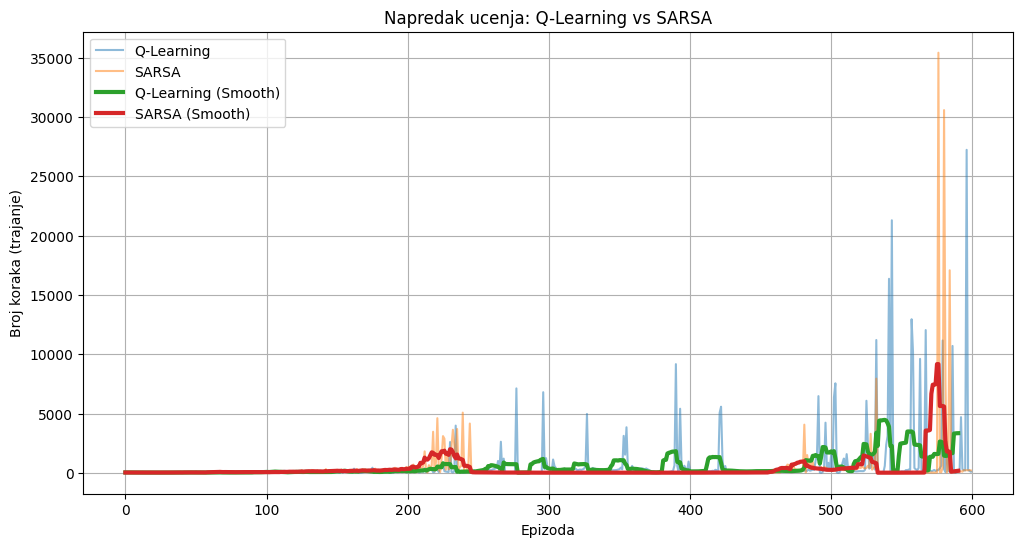

In [8]:
# Inicijalizacija okruzenja
my_model = CartPole(m=0.1, M=1.1, l=0.5, x_max=2.4, k=0.33)

# Pokretanje obuke
q_net_ql, ql_scores = train_q_learning(my_model, epochs=600)
q_net_sarsa, sarsa_scores = train_sarsa(my_model, epochs=600)

# Vizualizacija
def plot_results(ql_data, sarsa_data):
    plt.figure(figsize=(12, 6))
    plt.plot(ql_data, label="Q-Learning", alpha=0.5)
    plt.plot(sarsa_data, label="SARSA", alpha=0.5)

    # Dodajemo moving average za laksi pregled
    ql_smooth = np.convolve(ql_data, np.ones(10)/10, mode='valid')
    sarsa_smooth = np.convolve(sarsa_data, np.ones(10)/10, mode='valid')
    plt.plot(ql_smooth, label="Q-Learning (Smooth)", linewidth=3)
    plt.plot(sarsa_smooth, label="SARSA (Smooth)", linewidth=3)

    plt.title("Napredak ucenja: Q-Learning vs SARSA")
    plt.xlabel("Epizoda")
    plt.ylabel("Broj koraka (trajanje)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(ql_scores, sarsa_scores)

Sa grafika mozemo vidjeti sledece:
NAPOMENA:Podebljane linije prikazuju prosjek u prethodnim epizodama sta se desavalo dok su tanje trenutno stanje
Prve rezultate je prikazao SARSA algoritam sto je i donekle ocigledno jer je on "oprezniji" ide sigurnim putem on uzima buducu akciju u obzir ali opet sa dozom rezerve uz desavanja u proslosti.
Dok QL algoritam ide da kazem na "rizik" i ne obazire se puno na prethodne dogadjaje i vise je agresivniji.
Na ovom grafiku vidimo da je QL algoritam imao vise momenata bolje kontrole dok je SARSA pri kraju imao najveci vrhunac pred kraj sto i ima smisla jer je skupio dosta znanja do tada i isao sigurnijim putem mada i QL je imao dobre karakteristike pred kraj.
Na grafiku vidimo da je u prvih 200 epizoda klatno lose kontrolisano sto je i logicno dok model nije naucio malo vec kasnije poceo je da uci i na samom kraju je imao vrhunce.